In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [9]:
path = '/Users/jeppegrejspetersen/Code/Final_project_AppML/era5'
input_files_msl = [f for f in os.listdir(path) if f.endswith('.nc') and 'mean_sea_level_pressure' in f]
input_files_msl

['era5_1943_mean_sea_level_pressure.nc',
 'era5_1944_mean_sea_level_pressure.nc',
 'era5_1942_mean_sea_level_pressure.nc',
 'era5_1940_mean_sea_level_pressure.nc',
 'era5_1941_mean_sea_level_pressure.nc']

In [10]:
input_files_msl.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
input_files_msl

['era5_1940_mean_sea_level_pressure.nc',
 'era5_1941_mean_sea_level_pressure.nc',
 'era5_1942_mean_sea_level_pressure.nc',
 'era5_1943_mean_sea_level_pressure.nc',
 'era5_1944_mean_sea_level_pressure.nc']

In [20]:
##merge the files from the list
file_paths_msl = [os.path.join(path, fname) for fname in input_files_msl]

# Then open all files with xarray
ds_msl = xr.open_mfdataset(file_paths_msl, combine='by_coords').sel(latitude=slice(70, 40), longitude=slice(-80, 22))

mean_msl = ds_msl.msl.mean(dim='valid_time')
std_msl = ds_msl.msl.std(dim='valid_time')

msl_norm = (ds_msl.msl - mean_msl) / std_msl

ds_msl['msl_norm'] = msl_norm

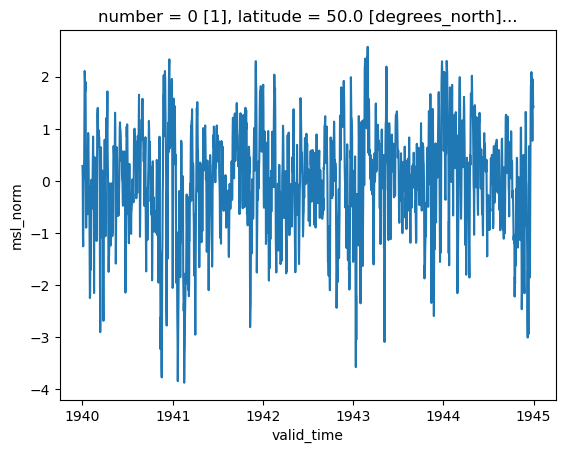

In [23]:
ds_msl.msl_norm.sel(longitude=0, latitude=50, method = 'nearest').plot()

In [76]:
msl_input = ds_msl.msl_norm.values
msl_input.shape

(1827, 121, 409)

['era5_1940_temperature_850hPa.nc', 'era5_1941_temperature_850hPa.nc', 'era5_1942_temperature_850hPa.nc', 'era5_1943_temperature_850hPa.nc', 'era5_1944_temperature_850hPa.nc']


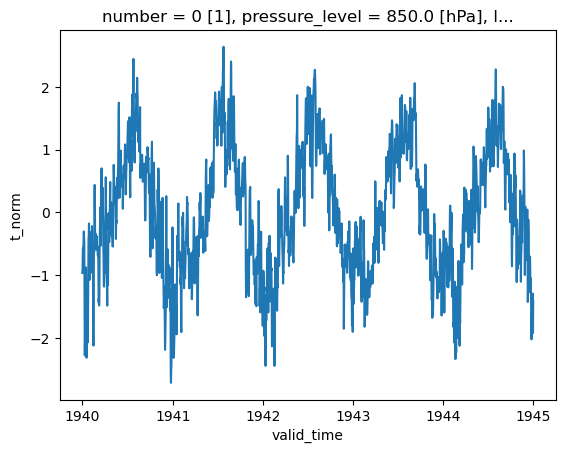

In [25]:
input_files_t850 = [f for f in os.listdir(path) if f.endswith('.nc') and '850' in f]
input_files_t850.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
print(input_files_t850)

file_paths_t850 = [os.path.join(path, fname) for fname in input_files_t850]
ds_t850 = xr.open_mfdataset(file_paths_t850, combine='by_coords').isel(pressure_level=0).sel(latitude=slice(70, 40), longitude=slice(-80, 22))

# Normalize temperature 't' at each grid point over time
# Calculate mean and std dev along time dimension
mean_t = ds_t850.t.mean(dim='valid_time')
std_t = ds_t850.t.std(dim='valid_time')

# Apply normalization
t_norm = (ds_t850.t - mean_t) / std_t

# Replace original temperature variable with normalized data (optional)
ds_t850['t_norm'] = t_norm

# Now plot the normalized time series at nearest grid point to lon=0, lat=0
ds_t850.t_norm.sel(longitude=0, latitude=0, method='nearest').plot()

t850_input = ds_t850.t_norm.values


In [26]:
target_prec = [f for f in os.listdir(path) if f.endswith('.nc') and 'total' in f]
target_prec.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
target_prec


['era5_1940_total_precipitation.nc',
 'era5_1941_total_precipitation.nc',
 'era5_1942_total_precipitation.nc',
 'era5_1943_total_precipitation.nc',
 'era5_1944_total_precipitation.nc']

(1827,)

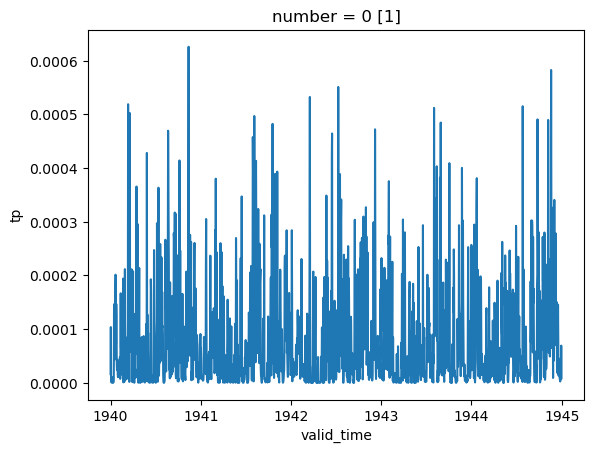

In [27]:
file_paths_prec = [os.path.join(path, fname) for fname in target_prec]
ds_prec = xr.open_mfdataset(file_paths_prec, combine='by_coords')
ds_prec = ds_prec.mean(dim= ['longitude', 'latitude'])
prec_target = ds_prec.tp.values
ds_prec.tp.plot()
prec_target.shape

In [28]:
import sys 

import torch
import torch.optim as optim
import torch.nn as nn
from torchinfo import summary
from torcheval.metrics.functional import binary_f1_score
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# import preprocessing as prep
# import postprocessing as post
# import training as train
# import models as mod
from sklearn.metrics import roc_curve, auc, recall_score, precision_score
import pickle
from torch.utils.data import TensorDataset, DataLoader



In [77]:
X = np.stack([t850_input, msl_input], axis=1)
X.shape

##split the last 250 time steps for testing
X_train = X[:-250]
X_test = X[-250:]
y_train = prec_target[:-250]
y_test = prec_target[-250:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(1577, 2, 121, 409)
(250, 2, 121, 409)
(1577,)
(250,)


In [75]:
X_tensor = torch.from_numpy(X_train)
y_tensor = torch.from_numpy(y_train)
print(X_tensor.shape)
print(y_tensor.shape)
X = X_tensor.view(1827-250, -1)
y = y_tensor.view(1827-250, 1)

# Create dataset
dataset = TensorDataset(X, y)


torch.Size([1577, 2, 121, 409])
torch.Size([1577])


In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FFNN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.3):
        super().__init__()

        hidden_dims = [4096, 2048, 2048, 2048, 2048, 1024, 1024, 1024, 1024, 1024, 1024, 256]
        #hidden_dims = [2048, 2048,1024, 1024,1024, 1024, 256]


        layers = []
        prev_dim = input_dim
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.BatchNorm1d(hdim)) 
            layers.append(nn.ELU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hdim

        # Final output layer
        layers.append(nn.Linear(prev_dim, 1))

        # Use Sequential for compactness
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Model setup
input_dim = 2 * 121 * 409

model = FFNN(input_dim)

In [82]:
class CNNRegressor(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super().__init__()

        # CNN feature extractor
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ELU(),
            nn.Dropout(dropout_rate),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.Dropout(dropout_rate),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Dropout(dropout_rate),

            nn.AdaptiveAvgPool2d((15, 15))  # Downsample to 64×15×15 = 14400
        )

        # Flattened size after pooling
        flattened_dim = 64 * 15 * 15

        # FFNN-style block (deep dense layers)
        hidden_dims = [2048, 1024, 1024, 512, 256]

        ffnn_layers = []
        prev_dim = flattened_dim
        for hdim in hidden_dims:
            ffnn_layers.append(nn.Linear(prev_dim, hdim))
            ffnn_layers.append(nn.BatchNorm1d(hdim))
            ffnn_layers.append(nn.ELU())
            ffnn_layers.append(nn.Dropout(dropout_rate))
            prev_dim = hdim

        ffnn_layers.append(nn.Linear(prev_dim, 1))  # Final regression output

        self.ffnn_layers = nn.Sequential(
            nn.Flatten(),
            *ffnn_layers
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.ffnn_layers(x)
        return x

model = CNNRegressor()

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader, random_split


# Data split (already good)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Loss, optimizer, and scheduler
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.view(-1, 2, 121, 409) ## for CNN comment out for FFNN
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= train_size

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.view(-1, 2, 121, 409) ## for CNN comment out for FFNN
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            val_loss += loss.item() * x_batch.size(0)
    val_loss /= val_size

    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f}")

    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss - 1e-4:  # small threshold for improvement
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # optional: save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered.")
            break


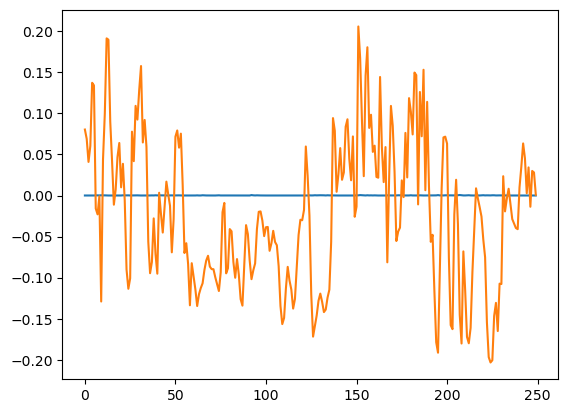

In [ ]:
plt.plot(y_test, label='True')
y_pred = model(torch.from_numpy(X_test).view(250, -1)).detach().numpy()
plt.plot(y_pred, label='Predicted')


In [45]:
y_test.shape

(250,)

In [48]:
y_pred.reshape(-1).shape

(250,)

In [49]:
def mean_square_error(x,y):
    a = (x-y)**2
    return a.mean()

In [50]:
mean_square_error(y_pred, y_test)

np.float32(6.0014878e-05)